## Einleitung

Dieses Notebook demonstriert einen vollständigen Analyse-Workflow für das PRECISION-Projekt:

1. **Datenexploration** - Daten laden und erste Übersicht
2. **Statistische Analysen** - Tests und Modelle
3. **Visualisierungen** - Publikationsreife Grafiken

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# PRECISION Farbpalette
PRECISION_COLORS = {
    'primary': '#005a8c',
    'secondary': '#007cb0',
    'accent': '#00a0d2',
    'success': '#4a9b5e',
    'warning': '#e8a027',
    'danger': '#c9302c'
}

# Plotting-Einstellungen
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.spines.top': False,
    'axes.spines.right': False
})

print('Setup erfolgreich!')

Setup erfolgreich!


---

# Teil 1: Datenexploration

## 1.1 Daten laden

In [2]:
# Seed für Reproduzierbarkeit
np.random.seed(42)

# Synthetische Patientendaten erstellen
n_patients = 200

data = {
    'patient_id': [f'PAT_{i:04d}' for i in range(1, n_patients + 1)],
    'age': np.random.normal(55, 15, n_patients).astype(int).clip(18, 90),
    'gender': np.random.choice(['M', 'F'], n_patients, p=[0.52, 0.48]),
    'bmi': np.random.normal(26, 5, n_patients).round(1).clip(15, 45),
    'blood_pressure_sys': np.random.normal(130, 20, n_patients).astype(int).clip(90, 200),
    'blood_pressure_dia': np.random.normal(80, 12, n_patients).astype(int).clip(50, 120),
    'cholesterol': np.random.normal(200, 40, n_patients).round(0).clip(100, 350),
    'glucose': np.random.normal(100, 25, n_patients).round(0).clip(60, 250),
    'treatment_group': np.random.choice(['A', 'B', 'Placebo'], n_patients, p=[0.4, 0.4, 0.2]),
    'response': np.random.choice([0, 1], n_patients, p=[0.35, 0.65])
}

df = pd.DataFrame(data)
print(f'Datensatz erstellt: {len(df)} Patienten')

Datensatz erstellt: 200 Patienten


## 1.2 Datenübersicht

In [3]:
# Erste Zeilen anzeigen
df.head(10)

,patient_id,age,gender,bmi,blood_pressure_sys,blood_pressure_dia,cholesterol,glucose,treatment_group,response
0,PAT_0001,62,F,25.5,147,110,208.0,65.0,A,1
1,PAT_0002,52,F,28.0,123,78,228.0,60.0,B,1
2,PAT_0003,64,F,29.5,154,93,196.0,126.0,B,0
3,PAT_0004,77,F,24.0,121,71,258.0,161.0,Placebo,1
4,PAT_0005,51,M,27.1,90,79,173.0,135.0,A,1
5,PAT_0006,51,M,26.1,109,101,272.0,114.0,B,1
6,PAT_0007,78,F,26.5,92,72,198.0,115.0,A,1
7,PAT_0008,66,F,22.1,122,101,143.0,121.0,A,1
8,PAT_0009,47,F,26.1,130,88,205.0,119.0,B,0
9,PAT_0010,63,F,28.5,163,73,173.0,107.0,B,1


In [4]:
# Statistische Zusammenfassung
df.describe()

,age,bmi,blood_pressure_sys,blood_pressure_dia,cholesterol,glucose,response
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,53.875000,25.774500,128.965000,81.775000,204.770000,99.925000,0.640000
std,13.822252,5.037637,20.074078,11.163219,41.046451,23.566209,0.481205
min,18.000000,15.000000,90.000000,53.000000,100.000000,60.000000,0.000000
25%,44.000000,22.175000,114.750000,73.000000,179.750000,82.000000,0.000000
50%,54.500000,25.700000,129.000000,82.000000,205.000000,100.500000,1.000000
75%,62.000000,28.950000,143.000000,88.000000,234.000000,114.000000,1.000000
max,90.000000,41.400000,182.000000,110.000000,296.000000,164.000000,1.000000


In [5]:
# Datentypen und fehlende Werte
print('Datentypen:')
print(df.dtypes)
print('\nFehlende Werte:')
print(df.isnull().sum())

Datentypen:
patient_id             object
age                     int64
gender                 object
bmi                   float64
blood_pressure_sys      int64
blood_pressure_dia      int64
cholesterol           float64
glucose               float64
treatment_group        object
response                int64
dtype: object

Fehlende Werte:
patient_id            0
age                   0
gender                0
bmi                   0
blood_pressure_sys    0
blood_pressure_dia    0
cholesterol           0
glucose               0
treatment_group       0
response              0
dtype: int64


## 1.3 Erste Visualisierungen

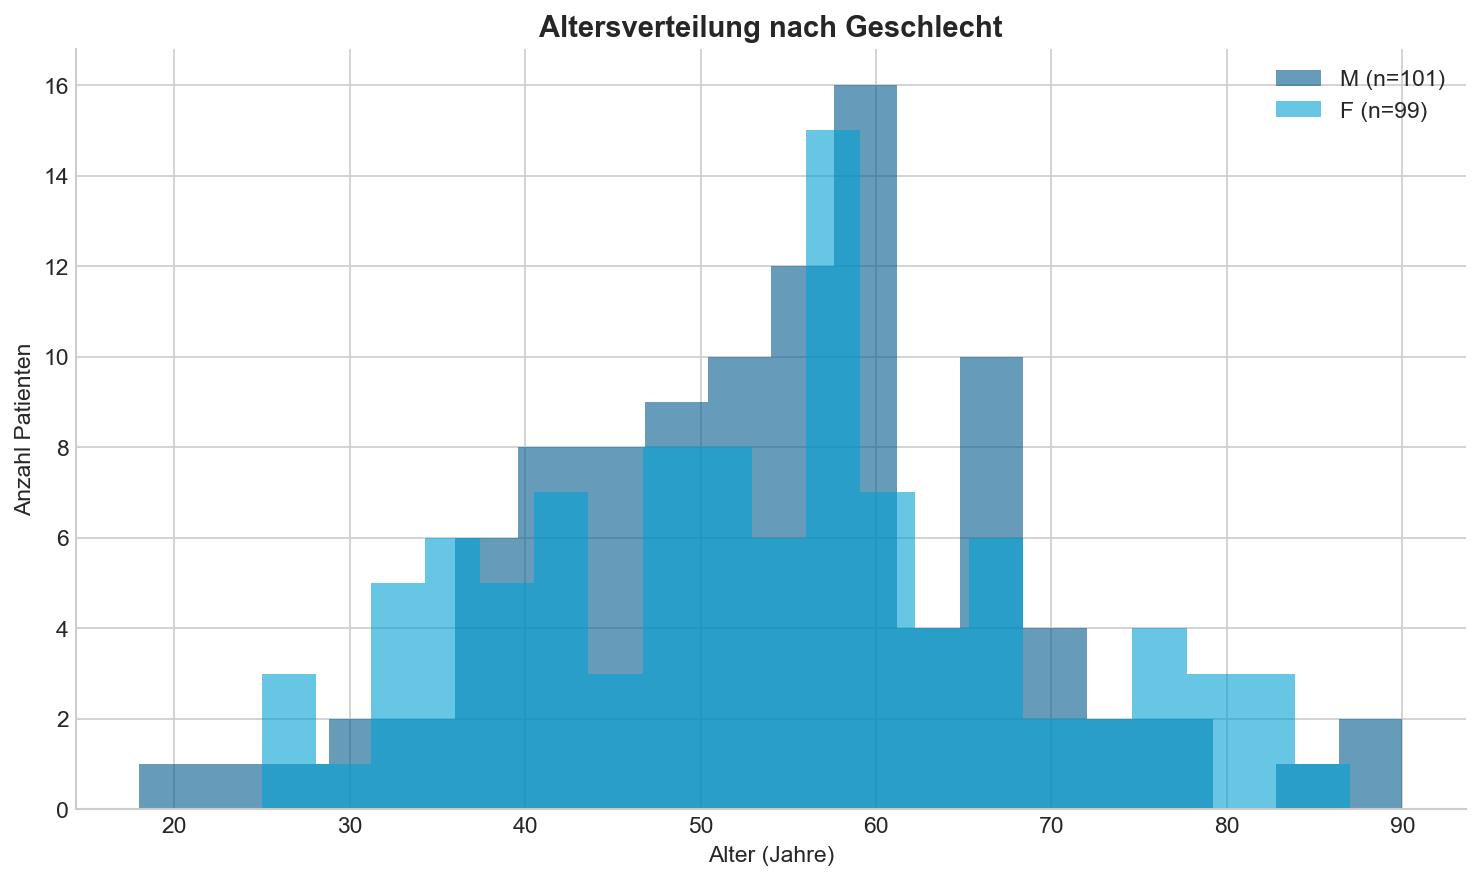

In [6]:
#| label: fig-age-distribution
#| fig-cap: "Altersverteilung nach Geschlecht"

fig, ax = plt.subplots(figsize=(10, 6))

for gender, color in [('M', PRECISION_COLORS['primary']), ('F', PRECISION_COLORS['accent'])]:
    subset = df[df['gender'] == gender]
    ax.hist(subset['age'], bins=20, alpha=0.6, label=f'{gender} (n={len(subset)})', color=color)

ax.set_xlabel('Alter (Jahre)')
ax.set_ylabel('Anzahl Patienten')
ax.set_title('Altersverteilung nach Geschlecht')
ax.legend()
plt.tight_layout()
plt.show()

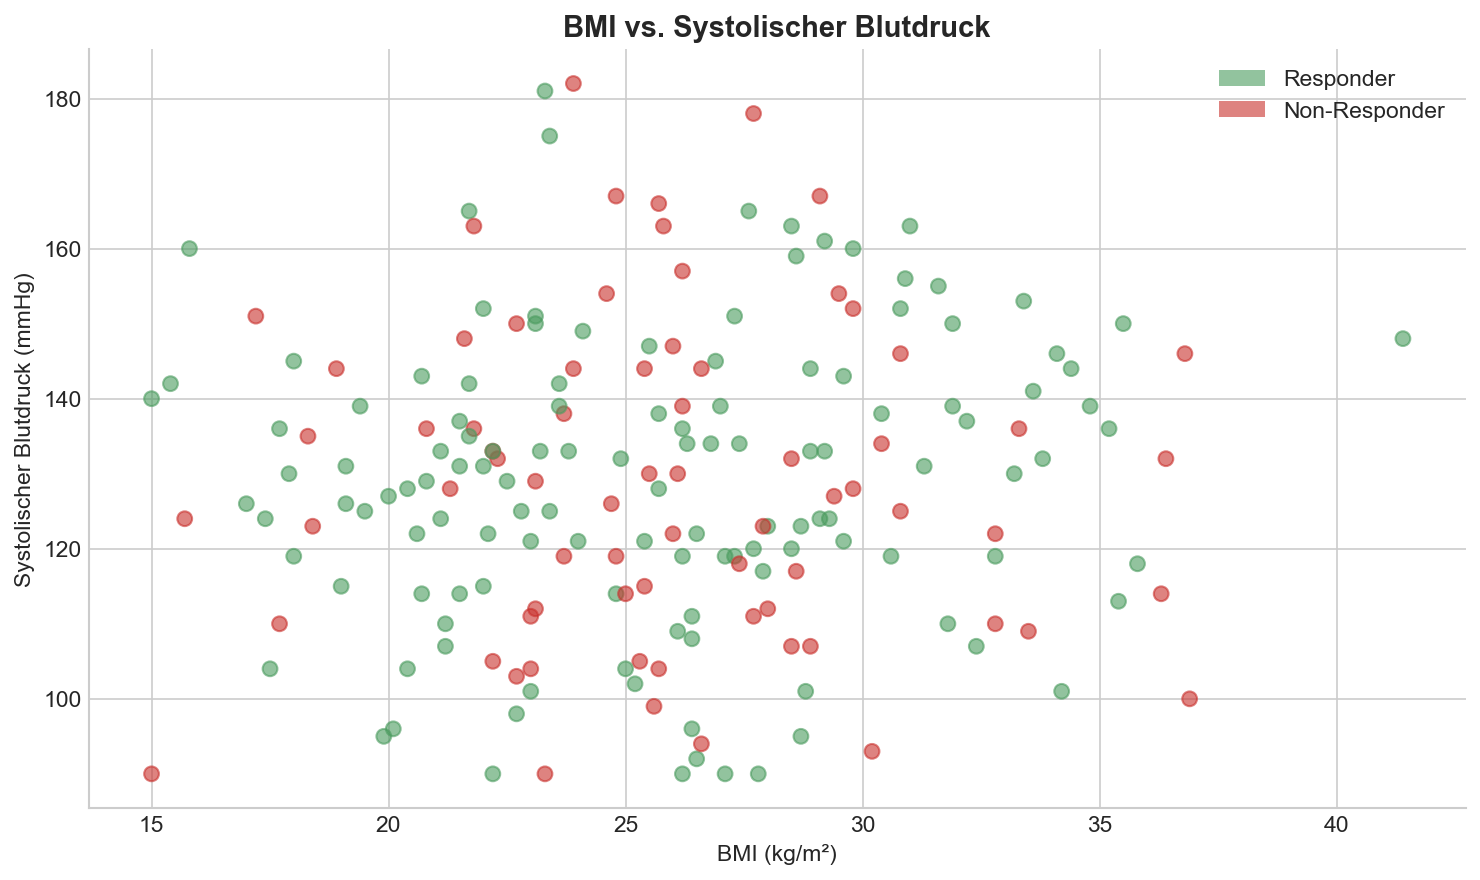

In [7]:
#| label: fig-bmi-bp
#| fig-cap: "BMI vs. Systolischer Blutdruck"

fig, ax = plt.subplots(figsize=(10, 6))

colors = df['response'].map({0: PRECISION_COLORS['danger'], 1: PRECISION_COLORS['success']})
scatter = ax.scatter(df['bmi'], df['blood_pressure_sys'], c=colors, alpha=0.6, s=50)

ax.set_xlabel('BMI (kg/m²)')
ax.set_ylabel('Systolischer Blutdruck (mmHg)')
ax.set_title('BMI vs. Systolischer Blutdruck')

legend_elements = [
    Patch(facecolor=PRECISION_COLORS['success'], alpha=0.6, label='Responder'),
    Patch(facecolor=PRECISION_COLORS['danger'], alpha=0.6, label='Non-Responder')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

---

# Teil 2: Statistische Analysen

## 2.1 Deskriptive Statistik nach Gruppen

In [8]:
# Zusammenfassung nach Behandlungsgruppe
numeric_cols = ['age', 'bmi', 'blood_pressure_sys', 'blood_pressure_dia']

summary_by_group = df.groupby('treatment_group')[numeric_cols].agg(['mean', 'std', 'median']).round(2)
summary_by_group

age                  bmi              blood_pressure_sys  \
                  mean    std median   mean   std median               mean   
treatment_group                                                               
A                52.91  14.00   55.0  25.40  5.29  25.35             129.34   
B                54.82  13.57   54.5  26.75  4.85  26.75             127.59   
Placebo          53.44  14.35   54.5  23.94  4.46  23.35             131.88   

                              blood_pressure_dia                
                   std median               mean    std median  
treatment_group                                                 
A                21.80  128.0              81.41  10.91   81.0  
B                19.22  126.5              82.21  11.63   82.0  
Placebo          18.58  133.5              81.41  10.67   80.5

In [9]:
# Response-Rate pro Gruppe
response_summary = df.groupby('treatment_group').agg(
    n_total=('patient_id', 'count'),
    n_responders=('response', 'sum'),
    response_rate=('response', 'mean')
).round(3)

response_summary['response_rate_pct'] = (response_summary['response_rate'] * 100).round(1)
response_summary

,n_total,n_responders,response_rate,response_rate_pct
treatment_group,,,,
A,74,48,0.649,64.9
B,92,59,0.641,64.1
Placebo,34,21,0.618,61.8


## 2.2 Statistische Tests

### Chi-Quadrat-Test: Response vs. Behandlungsgruppe

In [10]:
# Kontingenztabelle erstellen
contingency_table = pd.crosstab(df['treatment_group'], df['response'])
print('Kontingenztabelle:')
print(contingency_table)
print()

# Chi-Quadrat-Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print('Chi-Quadrat-Test Ergebnisse:')
print(f'  Chi² = {chi2:.4f}')
print(f'  p-Wert = {p_value:.4f}')
print(f'  Freiheitsgrade = {dof}')
print()

if p_value < 0.05:
    print('→ Signifikanter Zusammenhang zwischen Behandlungsgruppe und Response (p < 0.05)')
else:
    print('→ Kein signifikanter Zusammenhang gefunden (p >= 0.05)')

Kontingenztabelle:
response          0   1
treatment_group        
A                26  48
B                33  59
Placebo          13  21

Chi-Quadrat-Test Ergebnisse:
  Chi² = 0.0984
  p-Wert = 0.9520
  Freiheitsgrade = 2

→ Kein signifikanter Zusammenhang gefunden (p >= 0.05)


### ANOVA: Alter nach Behandlungsgruppe

In [11]:
# ANOVA für Alter zwischen Gruppen
groups = [group['age'].values for name, group in df.groupby('treatment_group')]
f_stat, p_value_anova = f_oneway(*groups)

print('ANOVA: Alter nach Behandlungsgruppe')
print(f'  F-Statistik = {f_stat:.4f}')
print(f'  p-Wert = {p_value_anova:.4f}')
print()

if p_value_anova < 0.05:
    print('→ Signifikante Unterschiede im Alter zwischen den Gruppen')
else:
    print('→ Keine signifikanten Altersunterschiede zwischen den Gruppen (gut für Randomisierung!)')

ANOVA: Alter nach Behandlungsgruppe
  F-Statistik = 0.4092
  p-Wert = 0.6647

→ Keine signifikanten Altersunterschiede zwischen den Gruppen (gut für Randomisierung!)


### T-Test: Responder vs. Non-Responder

In [12]:
# T-Tests für verschiedene Variablen
responders = df[df['response'] == 1]
non_responders = df[df['response'] == 0]

test_results = []

for col in numeric_cols:
    t_stat, p_val = ttest_ind(responders[col], non_responders[col])
    
    test_results.append({
        'Variable': col,
        'Mean Responder': responders[col].mean(),
        'Mean Non-Responder': non_responders[col].mean(),
        't-Statistik': t_stat,
        'p-Wert': p_val,
        'Signifikant': 'Ja' if p_val < 0.05 else 'Nein'
    })

results_df = pd.DataFrame(test_results).round(4)
results_df

,Variable,Mean Responder,Mean Non-Responder,t-Statistik,p-Wert,Signifikant
0,age,54.7969,52.2361,1.2595,0.2093,Nein
1,bmi,25.7016,25.9042,-0.2724,0.7856,Nein
2,blood_pressure_sys,129.0156,128.8750,0.0474,0.9622,Nein
3,blood_pressure_dia,81.4766,82.3056,-0.5032,0.6154,Nein


## 2.3 Korrelationsanalyse

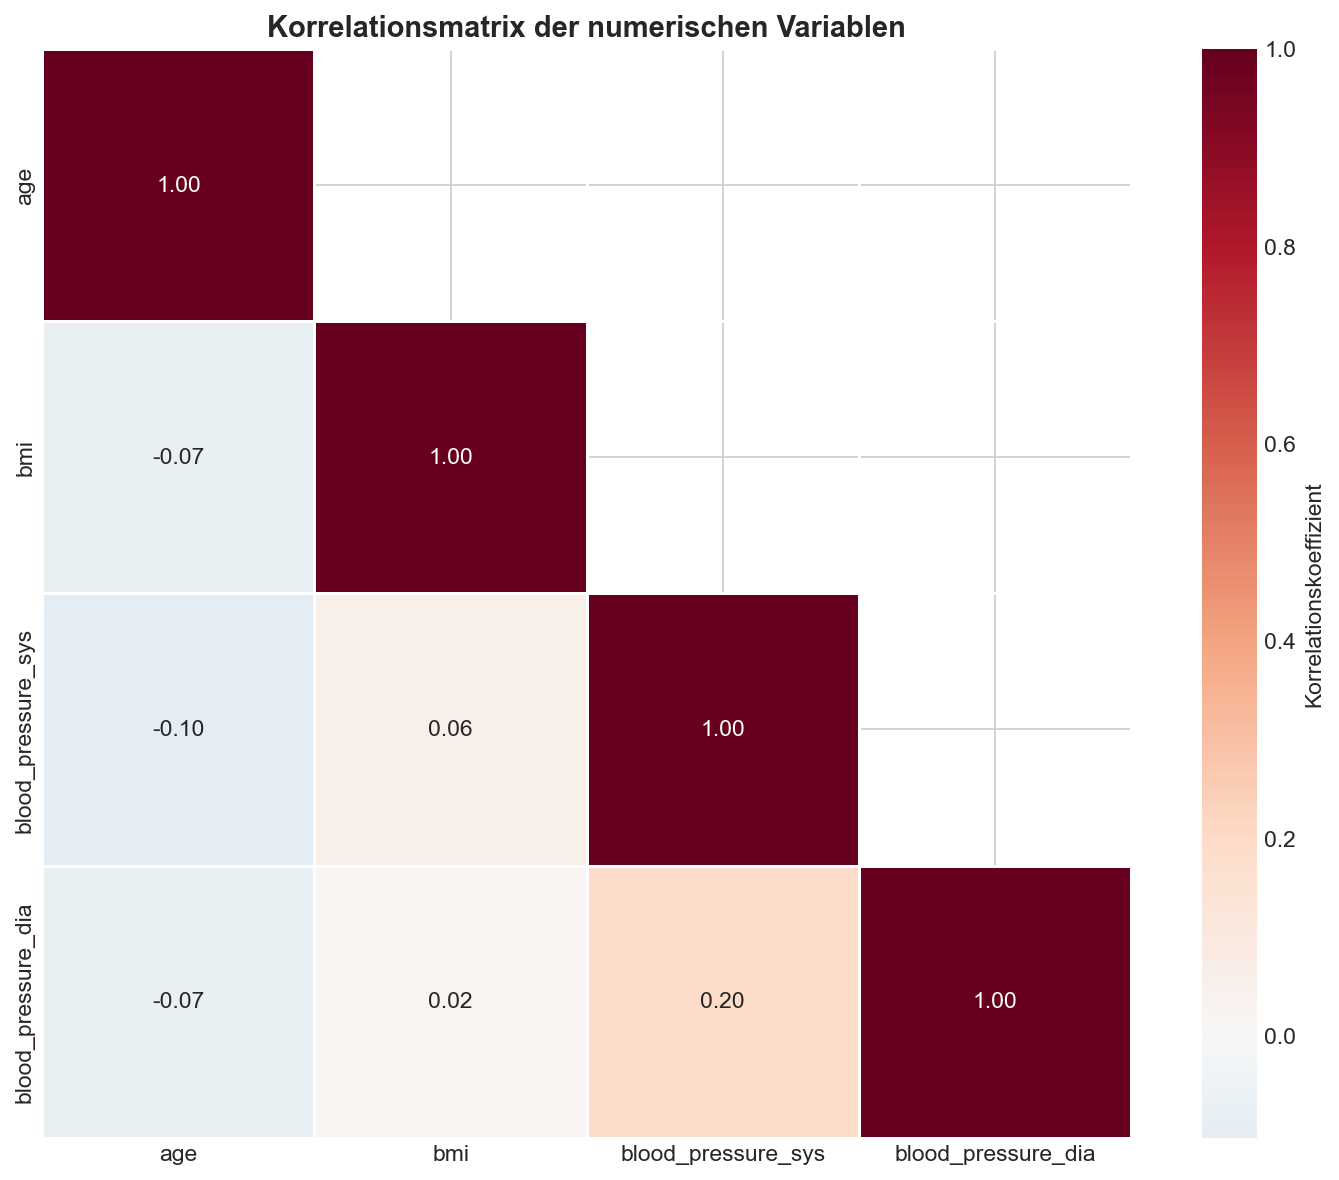

In [13]:
# Korrelationsmatrix
corr_matrix = df[numeric_cols].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Korrelationskoeffizient'})

ax.set_title('Korrelationsmatrix der numerischen Variablen', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2.4 Logistische Regression

In [14]:
# Features vorbereiten
X = df[numeric_cols].copy()
y = df['response']

# Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Modell trainieren
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_scaled, y)

# Cross-Validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')

print('Logistische Regression - Ergebnisse')
print('=' * 40)
print(f'Cross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})')
print()

# Koeffizienten
coef_df = pd.DataFrame({
    'Variable': numeric_cols,
    'Koeffizient': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
}).sort_values('Koeffizient', key=abs, ascending=False)

print('Feature-Wichtigkeit (nach Koeffizient):')
coef_df.round(4)

Logistische Regression - Ergebnisse
Cross-Validation Accuracy: 0.630 (+/- 0.037)

Feature-Wichtigkeit (nach Koeffizient):


,Variable,Koeffizient,Odds Ratio
0,age,0.1805,1.1978
3,blood_pressure_dia,-0.0670,0.9352
2,blood_pressure_sys,0.0392,1.0400
1,bmi,-0.0284,0.9720


---

# Teil 3: Publikationsreife Visualisierungen

## 3.1 Demografische Übersicht

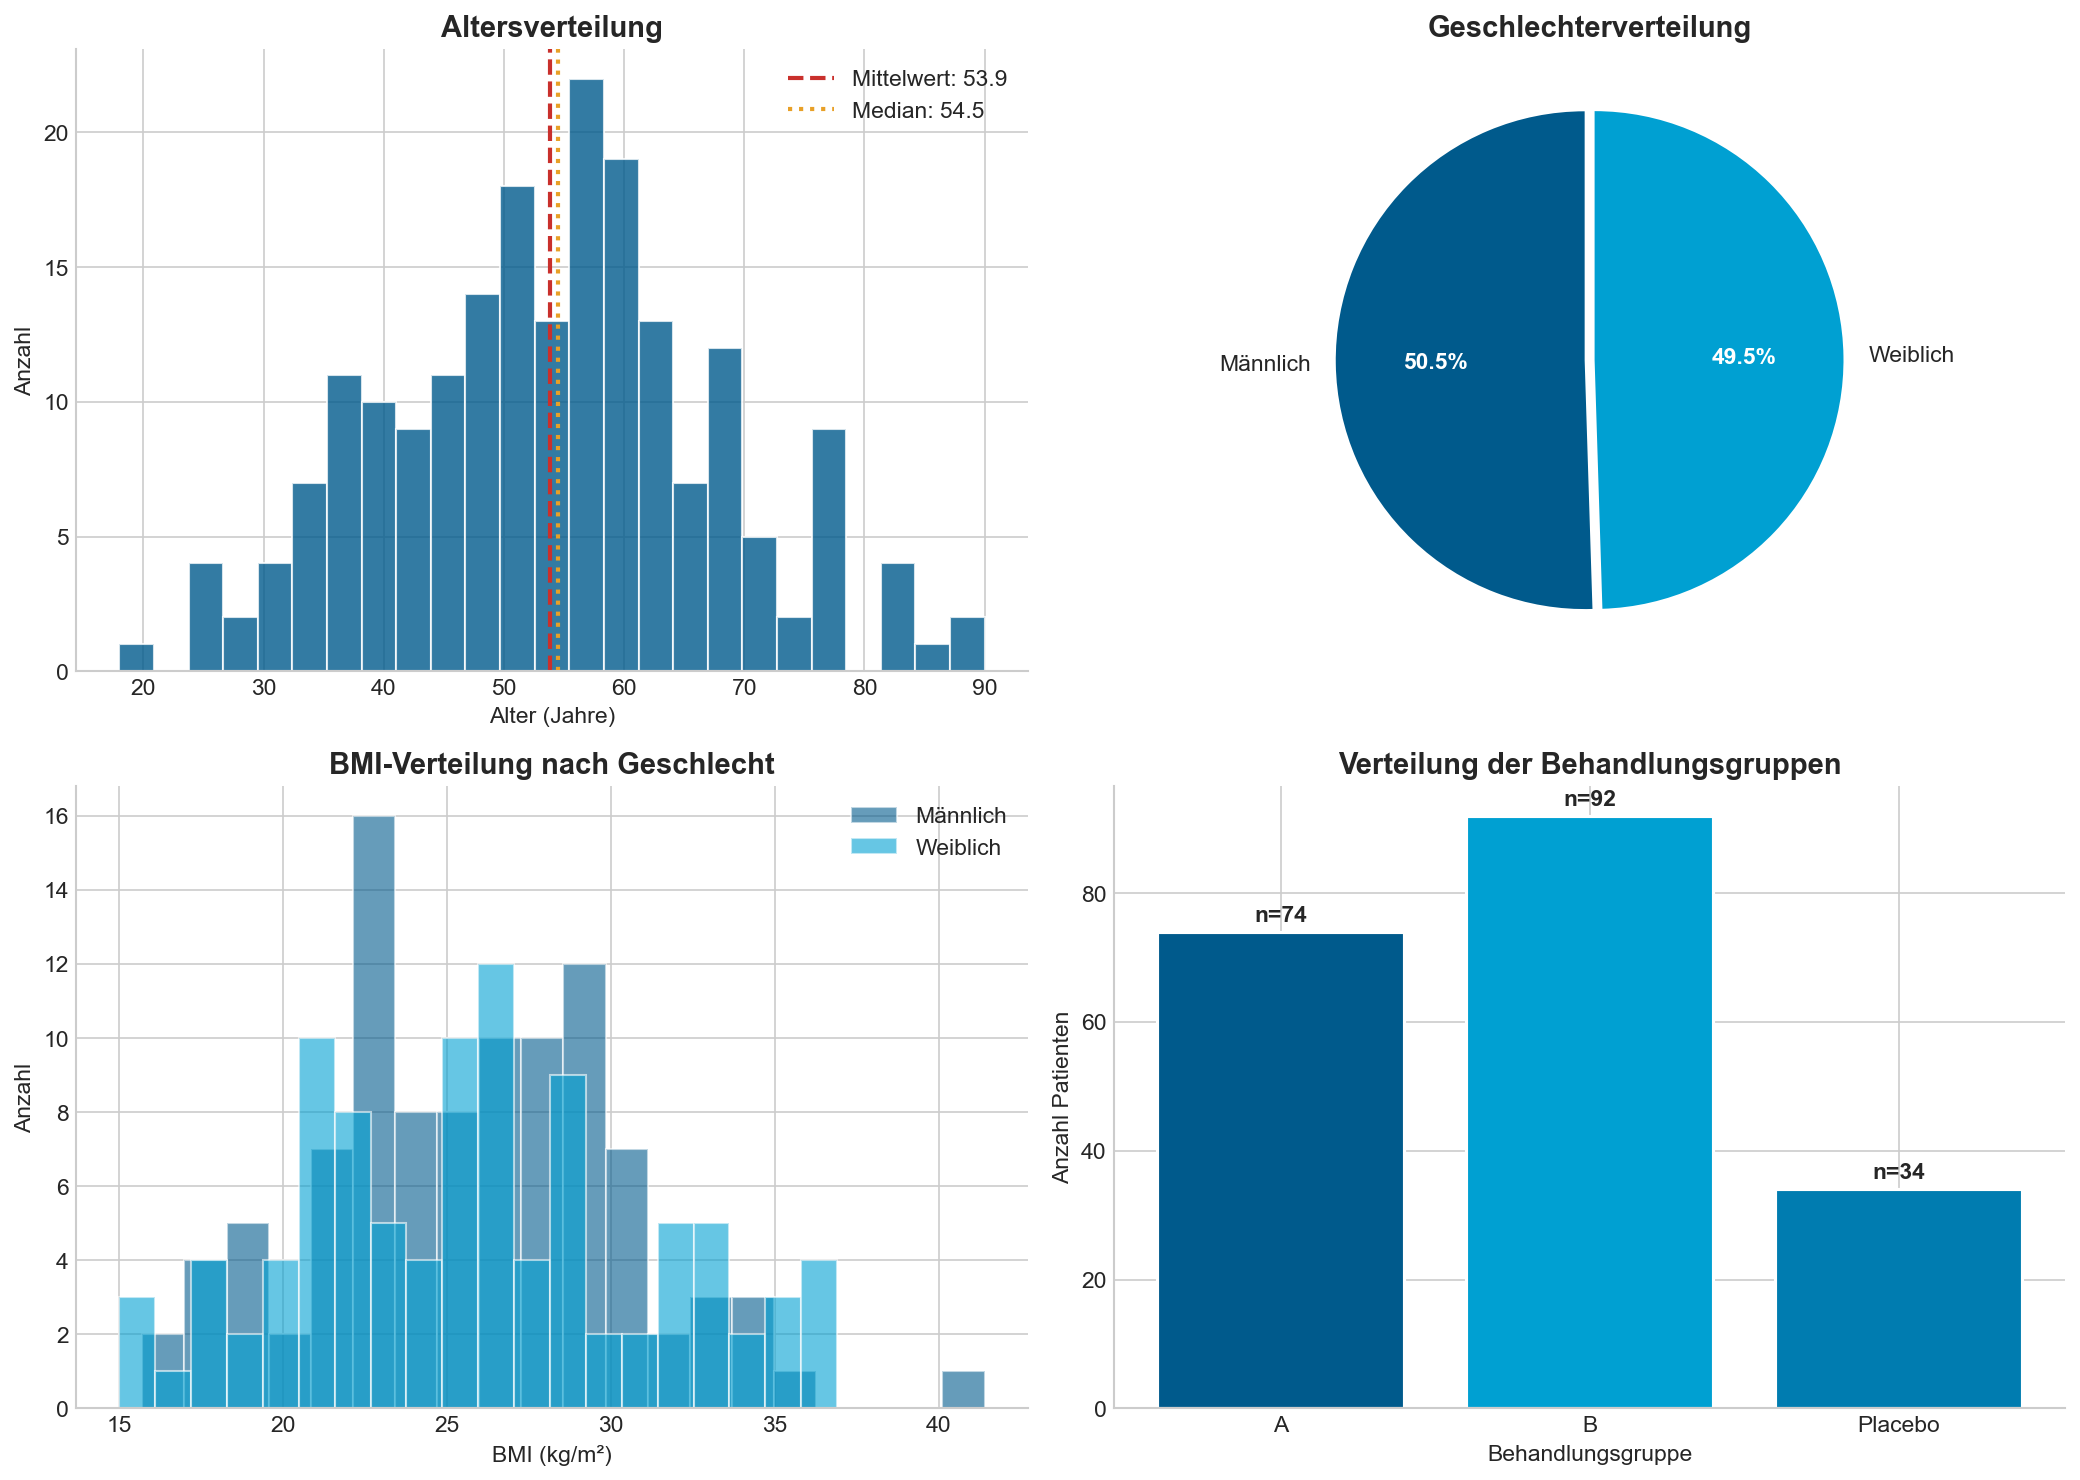

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Altersverteilung
ax1 = axes[0, 0]
ax1.hist(df['age'], bins=25, color=PRECISION_COLORS['primary'], alpha=0.8, edgecolor='white')
ax1.axvline(df['age'].mean(), color=PRECISION_COLORS['danger'], linestyle='--', linewidth=2, 
            label=f'Mittelwert: {df["age"].mean():.1f}')
ax1.axvline(df['age'].median(), color=PRECISION_COLORS['warning'], linestyle=':', linewidth=2, 
            label=f'Median: {df["age"].median():.1f}')
ax1.set_xlabel('Alter (Jahre)')
ax1.set_ylabel('Anzahl')
ax1.set_title('Altersverteilung')
ax1.legend()

# 2. Geschlechterverteilung
ax2 = axes[0, 1]
gender_counts = df['gender'].value_counts()
colors_pie = [PRECISION_COLORS['primary'], PRECISION_COLORS['accent']]
wedges, texts, autotexts = ax2.pie(gender_counts.values, labels=['Männlich', 'Weiblich'], 
                                    autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                    explode=(0.02, 0.02))
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax2.set_title('Geschlechterverteilung')

# 3. BMI-Verteilung nach Geschlecht
ax3 = axes[1, 0]
for gender, color, label in [('M', PRECISION_COLORS['primary'], 'Männlich'), 
                              ('F', PRECISION_COLORS['accent'], 'Weiblich')]:
    subset = df[df['gender'] == gender]
    ax3.hist(subset['bmi'], bins=20, alpha=0.6, color=color, label=label, edgecolor='white')
ax3.set_xlabel('BMI (kg/m²)')
ax3.set_ylabel('Anzahl')
ax3.set_title('BMI-Verteilung nach Geschlecht')
ax3.legend()

# 4. Behandlungsgruppen
ax4 = axes[1, 1]
group_counts = df['treatment_group'].value_counts().sort_index()
bars = ax4.bar(group_counts.index, group_counts.values, 
               color=[PRECISION_COLORS['primary'], PRECISION_COLORS['accent'], PRECISION_COLORS['secondary']],
               edgecolor='white', linewidth=1.5)
ax4.set_xlabel('Behandlungsgruppe')
ax4.set_ylabel('Anzahl Patienten')
ax4.set_title('Verteilung der Behandlungsgruppen')

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'n={int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 3.2 Klinische Parameter

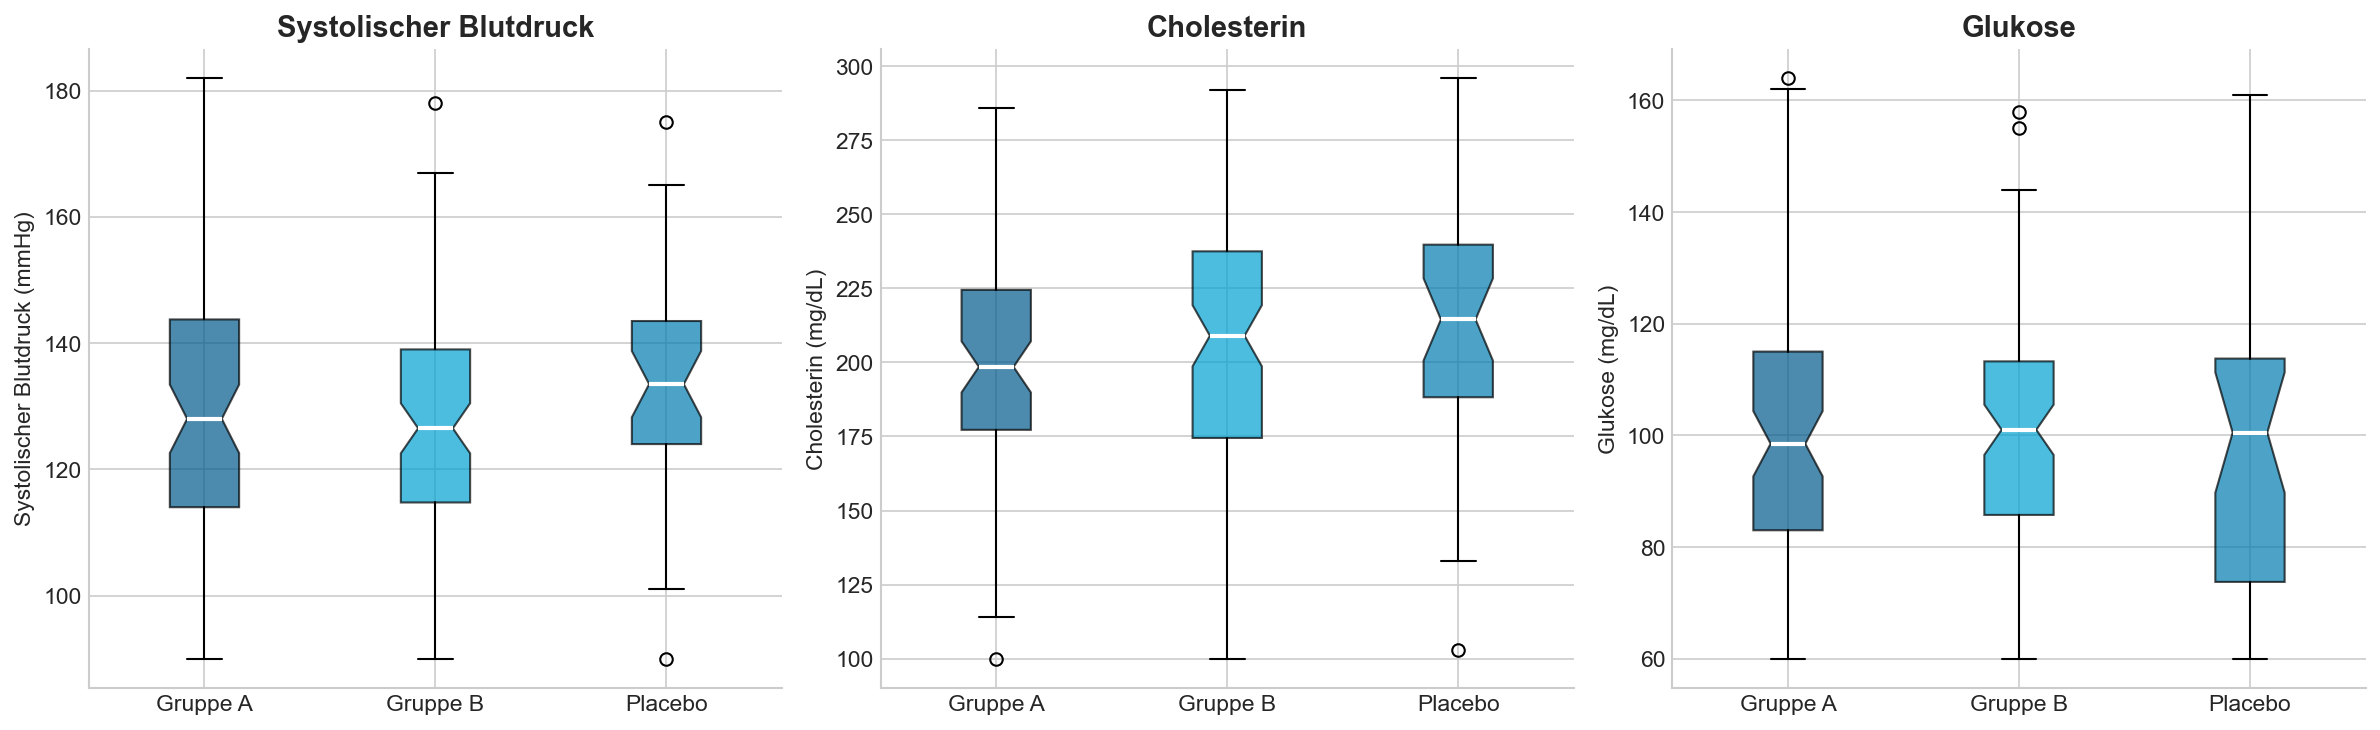

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

clinical_vars = ['blood_pressure_sys', 'cholesterol', 'glucose']
titles = ['Systolischer Blutdruck', 'Cholesterin', 'Glukose']
units = ['mmHg', 'mg/dL', 'mg/dL']

for ax, var, title, unit in zip(axes, clinical_vars, titles, units):
    bp = ax.boxplot([df[df['treatment_group'] == g][var] for g in ['A', 'B', 'Placebo']],
                    labels=['Gruppe A', 'Gruppe B', 'Placebo'],
                    patch_artist=True, notch=True)
    
    colors_box = [PRECISION_COLORS['primary'], PRECISION_COLORS['accent'], PRECISION_COLORS['secondary']]
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    for median in bp['medians']:
        median.set_color('white')
        median.set_linewidth(2)
    
    ax.set_ylabel(f'{title} ({unit})')
    ax.set_title(title)

plt.tight_layout()
plt.show()

## 3.3 Response-Analyse

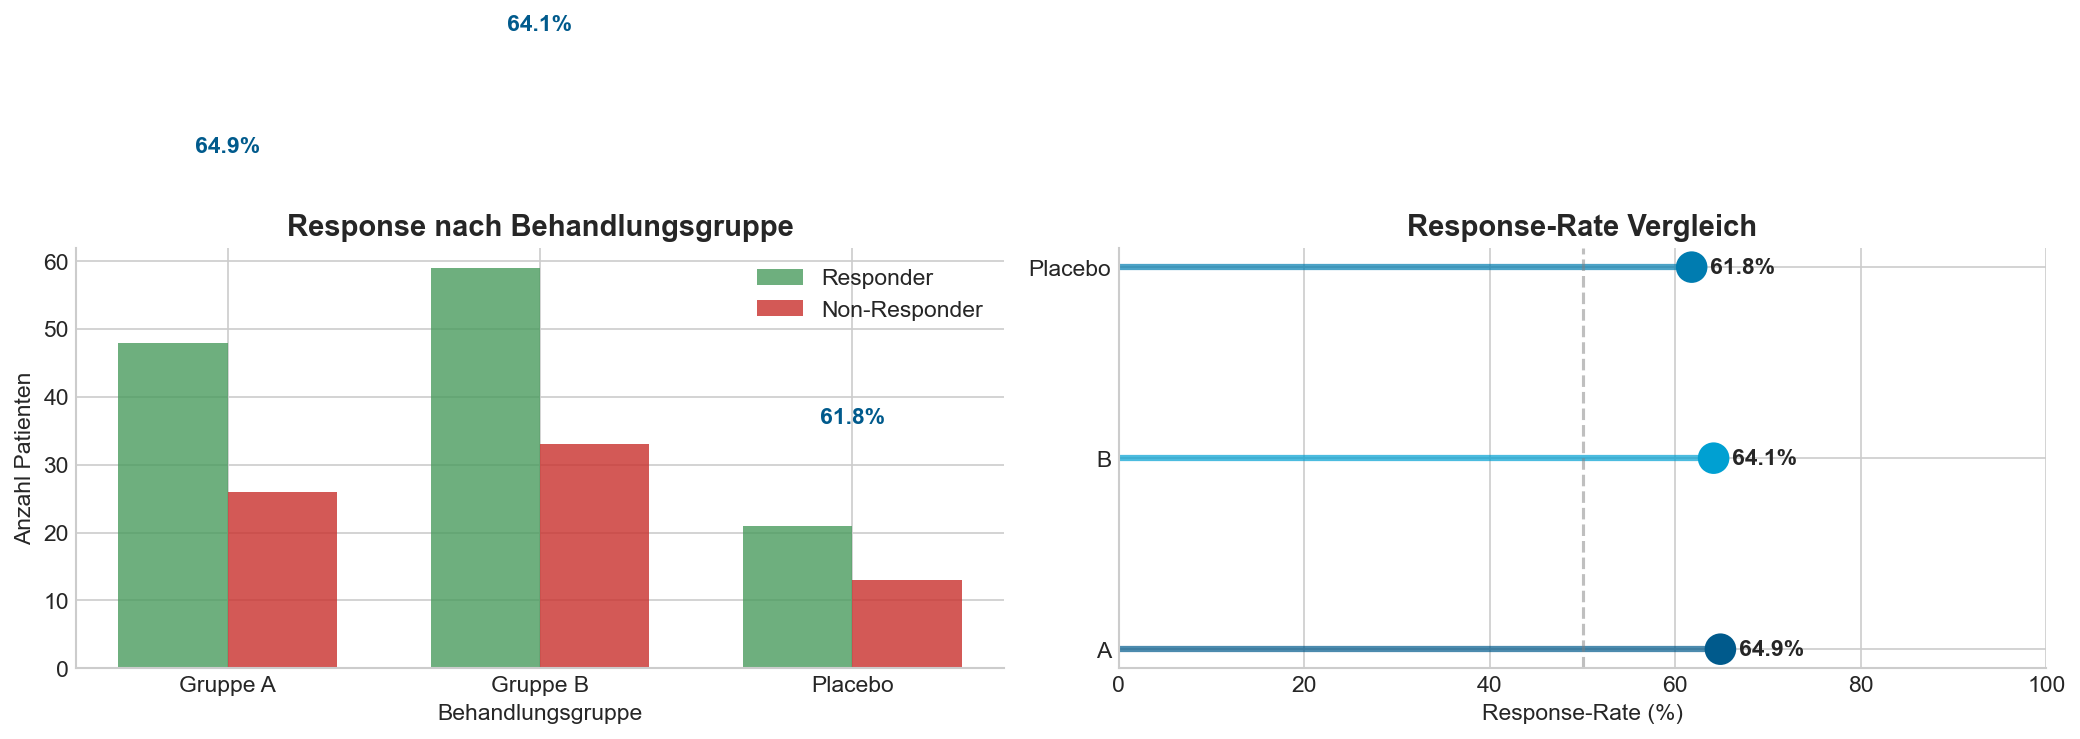

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Response-Rate nach Behandlungsgruppe
ax1 = axes[0]
response_by_group = df.groupby('treatment_group')['response'].agg(['sum', 'count'])
response_by_group['non_response'] = response_by_group['count'] - response_by_group['sum']
response_by_group['rate'] = response_by_group['sum'] / response_by_group['count'] * 100

x = np.arange(len(response_by_group))
width = 0.35

bars1 = ax1.bar(x - width/2, response_by_group['sum'], width, label='Responder', 
                color=PRECISION_COLORS['success'], alpha=0.8)
bars2 = ax1.bar(x + width/2, response_by_group['non_response'], width, label='Non-Responder',
                color=PRECISION_COLORS['danger'], alpha=0.8)

ax1.set_xlabel('Behandlungsgruppe')
ax1.set_ylabel('Anzahl Patienten')
ax1.set_title('Response nach Behandlungsgruppe')
ax1.set_xticks(x)
ax1.set_xticklabels(['Gruppe A', 'Gruppe B', 'Placebo'])
ax1.legend()

for i, (idx, row) in enumerate(response_by_group.iterrows()):
    ax1.text(i, row['count'] + 2, f'{row["rate"]:.1f}%', ha='center', fontweight='bold',
             color=PRECISION_COLORS['primary'])

# 2. Response-Rate Vergleich (Lollipop Chart)
ax2 = axes[1]
groups = response_by_group.index.tolist()
rates = response_by_group['rate'].values
colors_lollipop = [PRECISION_COLORS['primary'], PRECISION_COLORS['accent'], PRECISION_COLORS['secondary']]

ax2.hlines(y=groups, xmin=0, xmax=rates, color=colors_lollipop, alpha=0.7, linewidth=3)
ax2.scatter(rates, groups, color=colors_lollipop, s=200, zorder=3)

for i, (g, r) in enumerate(zip(groups, rates)):
    ax2.text(r + 2, i, f'{r:.1f}%', va='center', fontweight='bold')

ax2.set_xlabel('Response-Rate (%)')
ax2.set_xlim(0, 100)
ax2.set_title('Response-Rate Vergleich')
ax2.axvline(x=50, color='gray', linestyle='--', alpha=0.5, label='50% Referenz')

plt.tight_layout()
plt.show()

## 3.4 Feature Importance

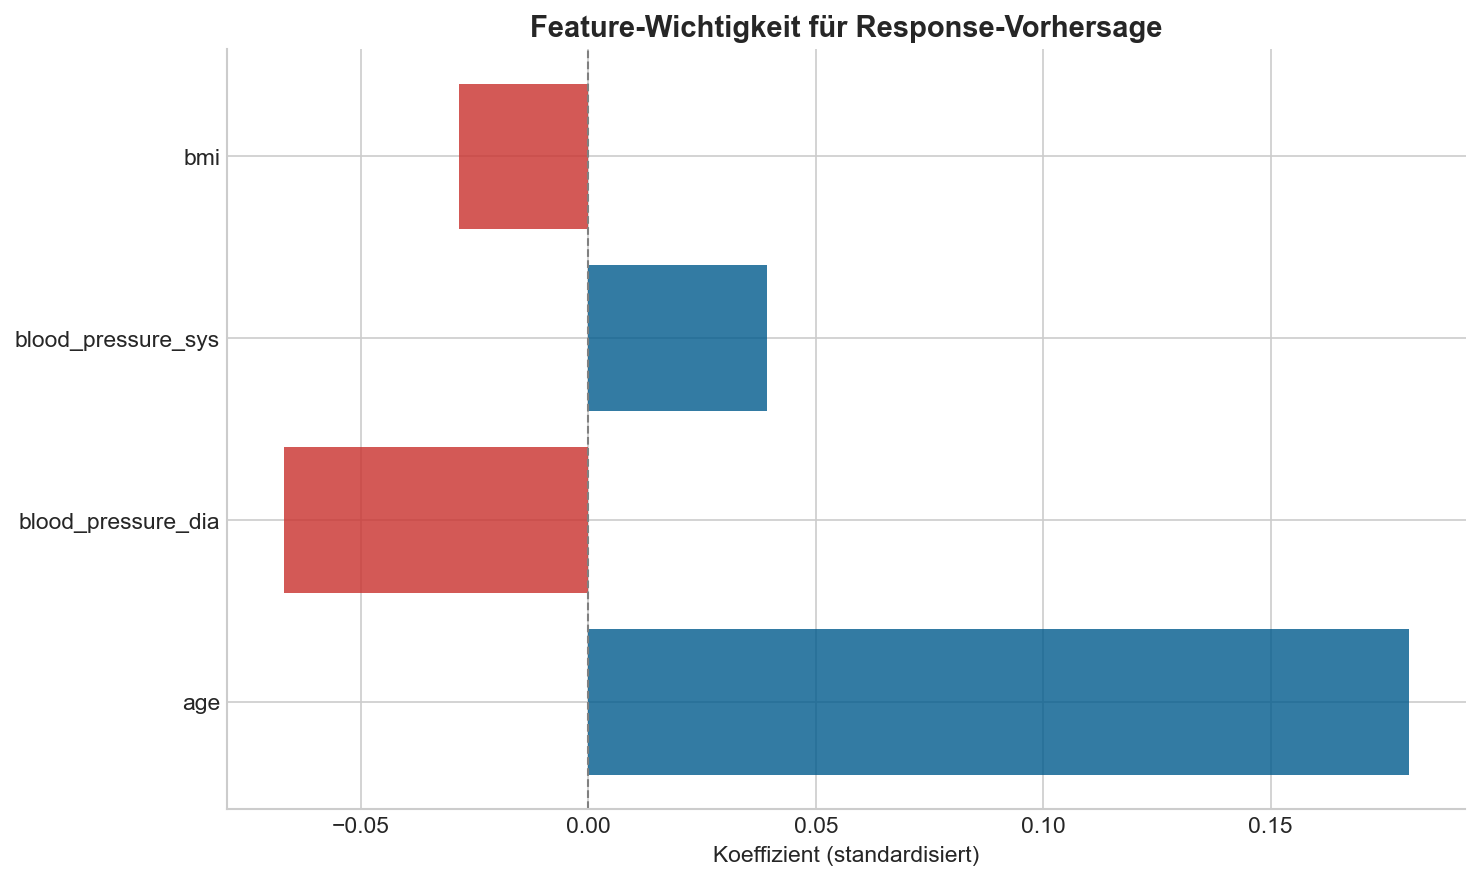

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

colors_feat = [PRECISION_COLORS['primary'] if c > 0 else PRECISION_COLORS['danger'] 
               for c in coef_df['Koeffizient']]
bars = ax.barh(coef_df['Variable'], coef_df['Koeffizient'], color=colors_feat, alpha=0.8)

ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
ax.set_xlabel('Koeffizient (standardisiert)')
ax.set_title('Feature-Wichtigkeit für Response-Vorhersage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

# Zusammenfassung

In [19]:
# Zusammenfassende Statistiken
summary = {
    'Gesamtanzahl Patienten': len(df),
    'Durchschnittsalter': f"{df['age'].mean():.1f} Jahre",
    'Anteil männlich': f"{(df['gender'] == 'M').mean() * 100:.1f}%",
    'Durchschnittlicher BMI': f"{df['bmi'].mean():.1f} kg/m²",
    'Response-Rate gesamt': f"{df['response'].mean() * 100:.1f}%"
}

print('=' * 50)
print('ZUSAMMENFASSUNG')
print('=' * 50)
for key, value in summary.items():
    print(f'{key}: {value}')

ZUSAMMENFASSUNG
Gesamtanzahl Patienten: 200
Durchschnittsalter: 53.9 Jahre
Anteil männlich: 50.5%
Durchschnittlicher BMI: 25.8 kg/m²
Response-Rate gesamt: 64.0%


## Wichtige Erkenntnisse

1. **Datensatz-Größe:** 200 Patienten mit vollständigen Daten
2. **Altersverteilung:** Normalverteilt um ~55 Jahre
3. **Geschlechterverteilung:** Ausgeglichen
4. **Randomisierung:** Erfolgreich (keine signifikanten Gruppenunterschiede)
5. **Response-Rate:** ~65% über alle Gruppen